In [211]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

In [212]:
df = pd.read_excel('fig3.xlsx')
print(df)

       cycles crack length       cycles.1 crack length.1       cycles.2  \
0         NaN           mm            NaN             mm            NaN   
1    R=0.1,CA     R=0.1,CA  R=0.1,OLR=1.5  R=0.1,OLR=1.5  R=0.1,OLR=2.0   
2        9210      10.2752           9984        10.3196           7528   
3       11186      10.3271          12236         10.371           9281   
4       13372      10.3835          17057         10.423          11247   
..        ...          ...            ...            ...            ...   
245    137559      23.1331         190757         23.223            NaN   
246    137629      23.1878         190838        23.2772            NaN   
247    137691      23.2419         190894        23.3292            NaN   
248    137747      23.2949         190971        23.3804            NaN   
249    137810      23.3462         191033        23.4311            NaN   

    crack length.2  cycles.3 crack length.3       cycles.4 crack length.4  \
0               mm    

In [213]:
# Keep the only first two columns
df1 = df.iloc[:, 0:2]

# Add two new columnns using the first cell of second row
# It can contain one or thow values in form of R=some or OLR=some
# We shoudl parse it and add two new columns
df1['R'] = df1.iloc[1, 0].split('R=')[1].split(',')[0] if 'R=' in df1.iloc[1, 0] else None
df1['OLR'] = df1.iloc[1, 0].split('OLR=')[1] if 'OLR=' in df1.iloc[1, 0] else None


# Remove the first and second row
df1 = df1.iloc[2:, :]

print(df1)


     cycles crack length    R   OLR
2      9210      10.2752  0.1  None
3     11186      10.3271  0.1  None
4     13372      10.3835  0.1  None
5     15492      10.4358  0.1  None
6     17102      10.4875  0.1  None
..      ...          ...  ...   ...
245  137559      23.1331  0.1  None
246  137629      23.1878  0.1  None
247  137691      23.2419  0.1  None
248  137747      23.2949  0.1  None
249  137810      23.3462  0.1  None

[248 rows x 4 columns]


/tmp/ipykernel_7698/2228567306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['R'] = df1.iloc[1, 0].split('R=')[1].split(',')[0] if 'R=' in df1.iloc[1, 0] else None
/tmp/ipykernel_7698/2228567306.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OLR'] = df1.iloc[1, 0].split('OLR=')[1] if 'OLR=' in df1.iloc[1, 0] else None


In [214]:
# Split the data into experiments
E1 = df.iloc[:, 0:2]
E1 = E1.iloc[2:, :]
E1.columns = ['cycles', 'crack length']
E1['R'], E1['OLR'] = 0.1, None

E2 = df.iloc[:, 2:4]
E2 = E2.iloc[2:, :]
E2.columns = ['cycles', 'crack length']
E2['R'], E2['OLR'] = 0.1, 1.5

E3 = df.iloc[:, 4:6]
E3 = E3.iloc[2:, :]
E3.columns = ['cycles', 'crack length']
E3['R'], E3['OLR'] = 0.1, 2.0

E4 = df.iloc[:, 6:8]
E4 = E4.iloc[2:, :]
E4.columns = ['cycles', 'crack length']
E4['R'], E4['OLR'] = 0.3, None

E5 = df.iloc[:, 8:10]
E5 = E5.iloc[2:, :]
E5.columns = ['cycles', 'crack length']
E5['R'], E5['OLR'] = 0.3, 1.5

E6 = df.iloc[:, 10:12]
E6 = E6.iloc[2:, :]
E6.columns = ['cycles', 'crack length']
E6['R'], E6['OLR'] = 0.3, 2.0

E7 = df.iloc[:, 12:14]
E7 = E7.iloc[2:, :]
E7.columns = ['cycles', 'crack length']
E7['R'], E7['OLR'] = 0.5, None

E8 = df.iloc[:, 14:16]
E8 = E8.iloc[2:, :]
E8.columns = ['cycles', 'crack length']
E8['R'], E8['OLR'] = 0.5, 1.5

E9 = df.iloc[:, 16:18]
E9 = E9.iloc[2:, :]
E9.columns = ['cycles', 'crack length']
E9['R'], E9['OLR'] = 0.5, 2.0

E10 = df.iloc[:, 18:20]
E10 = E10.iloc[2:, :]
E10.columns = ['cycles', 'crack length']
E10['R'], E10['OLR'] = 0.7, None

E11 = df.iloc[:, 20:22]
E11 = E11.iloc[2:, :]
E11.columns = ['cycles', 'crack length']
E11['R'], E11['OLR'] = 0.7, 1.5

E12 = df.iloc[:, 22:24]
E12 = E12.iloc[2:, :]
E12.columns = ['cycles', 'crack length']
E12['R'], E12['OLR'] = 0.7, 2.0

# Concatenate all the experiments into one dataframe
data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])

# Replace the NaN values with 0 FOR OLR
data['OLR'] = data['OLR'].fillna(0)

print(data)

# Remove the rows with NaN values
data = data.dropna()

print(data)


    cycles crack length    R  OLR
2     9210      10.2752  0.1  0.0
3    11186      10.3271  0.1  0.0
4    13372      10.3835  0.1  0.0
5    15492      10.4358  0.1  0.0
6    17102      10.4875  0.1  0.0
..     ...          ...  ...  ...
245    NaN          NaN  0.7  2.0
246    NaN          NaN  0.7  2.0
247    NaN          NaN  0.7  2.0
248    NaN          NaN  0.7  2.0
249    NaN          NaN  0.7  2.0

[2976 rows x 4 columns]
     cycles crack length    R  OLR
2      9210      10.2752  0.1  0.0
3     11186      10.3271  0.1  0.0
4     13372      10.3835  0.1  0.0
5     15492      10.4358  0.1  0.0
6     17102      10.4875  0.1  0.0
..      ...          ...  ...  ...
133  398915      16.7087  0.7  2.0
134  400001      16.6873  0.7  2.0
135  400099      16.7398  0.7  2.0
136  401354      16.7946  0.7  2.0
137  404712      16.9001  0.7  2.0

[2417 rows x 4 columns]


/tmp/ipykernel_7698/2997046254.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])


In [215]:
print(data.shape)

print(data.head())

# Check for missing values
print("Train data missing values:")
print(data.isna().values.any())

# Check for empty values
print("Train data empty values:")
print(data.isnull().values.any())

# Check for duplicate rows
print("Train data duplicate rows:")
print(data.duplicated().values.any())



(2417, 4)
  cycles crack length    R  OLR
2   9210      10.2752  0.1  0.0
3  11186      10.3271  0.1  0.0
4  13372      10.3835  0.1  0.0
5  15492      10.4358  0.1  0.0
6  17102      10.4875  0.1  0.0
Train data missing values:
False
Train data empty values:
False
Train data duplicate rows:
False


In [216]:
X = data.drop('crack length', axis=1).values
y = data['crack length'].values

print(X.shape)
print(y.shape)

(2417, 3)
(2417,)


In [217]:
# Create two separate test sets
test_data1 = data[(data['R'] == 0.5) & (data['OLR'] == 0.0)]
test_data2 = data[(data['R'] == 0.5) & (data['OLR'] == 1.5)]
print(test_data2)

# Create a training set that exclude the first test set
train_data1 = pd.concat([data, test_data1]).drop_duplicates(keep=False)

# Create a training set that exclude the second test set
train_data2 = pd.concat([data, test_data2]).drop_duplicates(keep=False)

# Split the training data sets into features and target
X_train1 = train_data1.drop('crack length', axis=1)
y_train1 = train_data1['crack length']

X_train2 = train_data2.drop('crack length', axis=1)
y_train2 = train_data2['crack length']

# Split the test data sets into features and target
X_test1 = test_data1.drop('crack length', axis=1)
y_test1 = test_data1['crack length']

X_test2 = test_data2.drop('crack length', axis=1)
y_test2 = test_data2['crack length']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled1 = scaler.fit_transform(X_train1)
X_train_scaled2 = scaler.fit_transform(X_train2)

X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

# Shuffle the data
X_train_scaled1, y_train1 = shuffle(X_train_scaled1, y_train1, random_state=42)
X_train_scaled2, y_train2 = shuffle(X_train_scaled2, y_train2, random_state=42)

X_test1_scaled, y_test1 = shuffle(X_test1_scaled, y_test1, random_state=42)
X_test2_scaled, y_test2 = shuffle(X_test2_scaled, y_test2, random_state=42)


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# scaler = MinMaxScaler(feature_range = (0, 1))
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

#print(np.mean(X), np.std(X))
#print(np.mean(X_train_scaled), np.std(X_train_scaled))

     cycles crack length    R  OLR
2     11833       10.447  0.5  1.5
3     14591      10.4994  0.5  1.5
4     17402      10.5509  0.5  1.5
5     20196      10.6021  0.5  1.5
6     22436      10.6565  0.5  1.5
..      ...          ...  ...  ...
193  264150      20.1518  0.5  1.5
194  264465      20.2044  0.5  1.5
195  264718       20.258  0.5  1.5
196  264985      20.3139  0.5  1.5
197  265321      20.3711  0.5  1.5

[196 rows x 4 columns]


Test MSE: 3.5111871349615


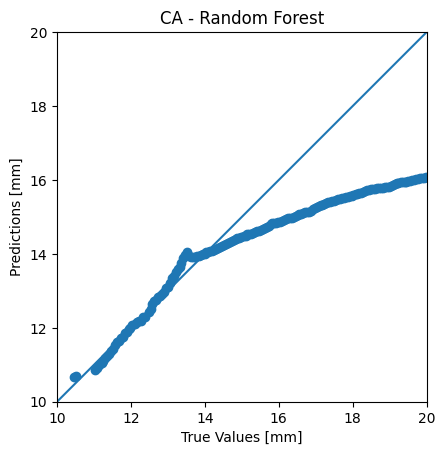

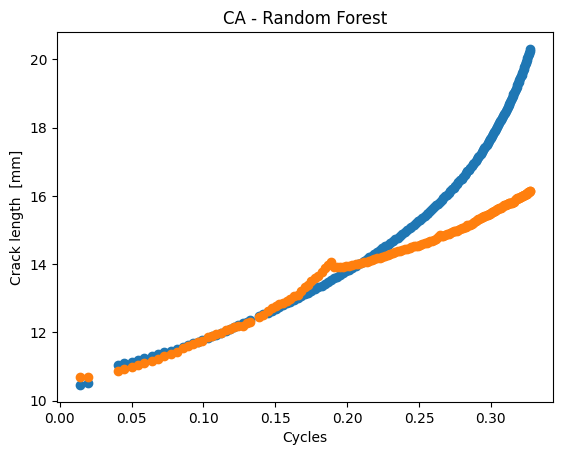

In [218]:
# Predict crack length vs. the number of cycles for CA using Random Forest

# Train the model
model1 = RandomForestRegressor(n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features='sqrt',
                                  max_depth=110, bootstrap=True)

model1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = model1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'Test MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Random Forest')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1)
plt.scatter(X_test1_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - Random Forest')
plt.show()


Test MSE: 2.3102257577396466


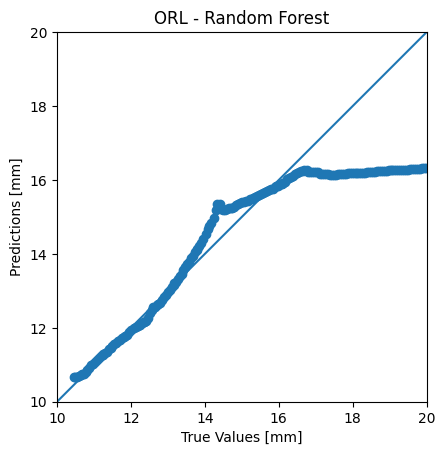

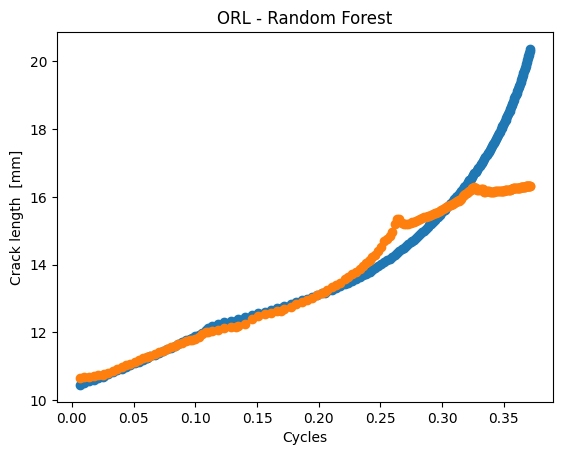

In [219]:
# Predict crack length vs. the number of cycles for ORL

# Train the first model
model2 = RandomForestRegressor(n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features='sqrt',
                                  max_depth=110, bootstrap=True)

model2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = model2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f'Test MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - Random Forest')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2)
plt.scatter(X_test2_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - Random Forest')
plt.show()

Test MSE: 3.223217379438203


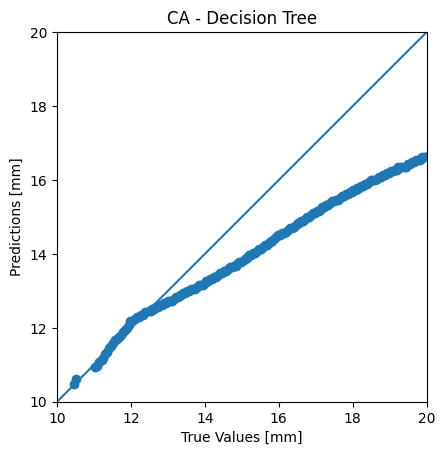

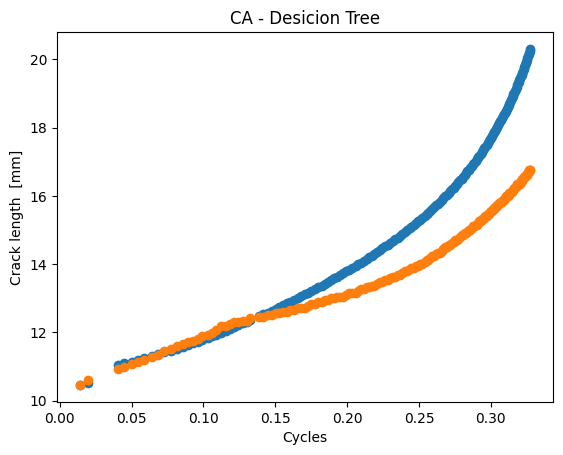

In [220]:
# Predict crack length vs. the number of cycles for CA using Decision Tree

# Train the model
model1 = DecisionTreeRegressor(max_depth=12)

model1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = model1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'Test MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Decision Tree')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1)
plt.scatter(X_test1_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - Desicion Tree')
plt.show()


Test MSE: 6.959753502219389


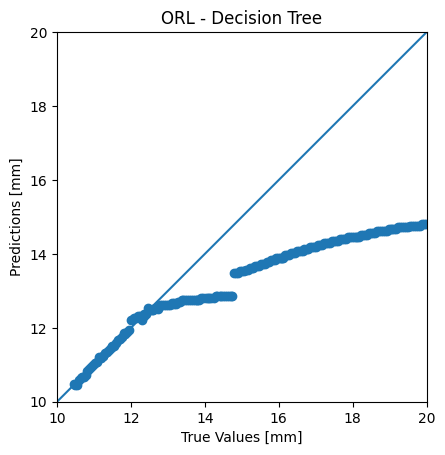

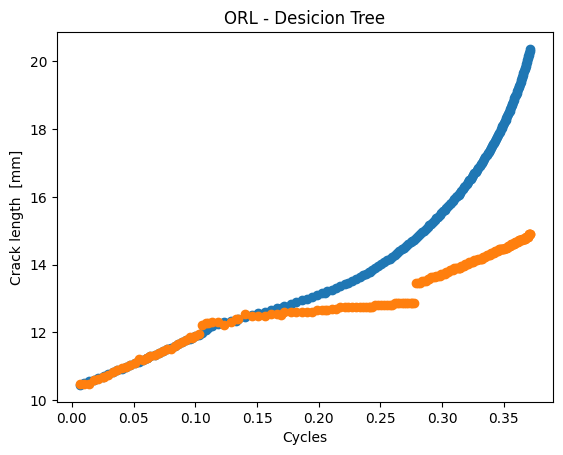

In [221]:
# Predict crack length vs. the number of cycles for ORL using Decision Tree

# Train the model
model2 = DecisionTreeRegressor(max_depth=12)

model2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = model2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f'Test MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - Decision Tree')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2)
plt.scatter(X_test2_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - Desicion Tree')
plt.show()

Test MSE: 1.9318811713413093


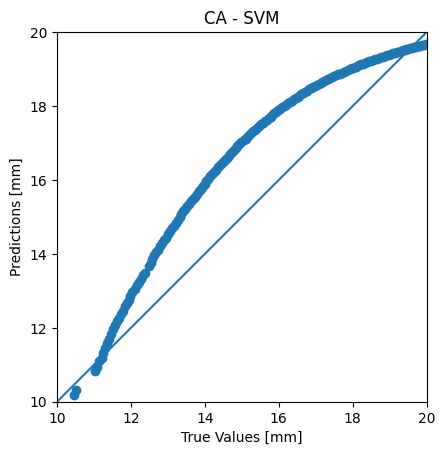

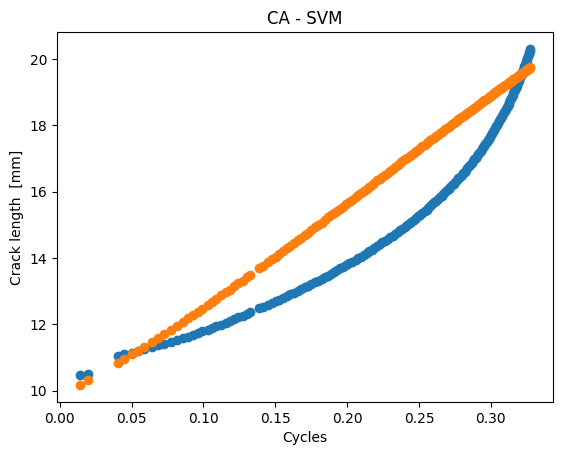

In [222]:
# Predict crack length vs. the number of cycles for CA using Support Vector Machine

# Train the model
model1 = svm.SVR()

model1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = model1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'Test MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - SVM')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1)
plt.scatter(X_test1_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - SVM')
plt.show()



Test MSE: 2.005435689727745


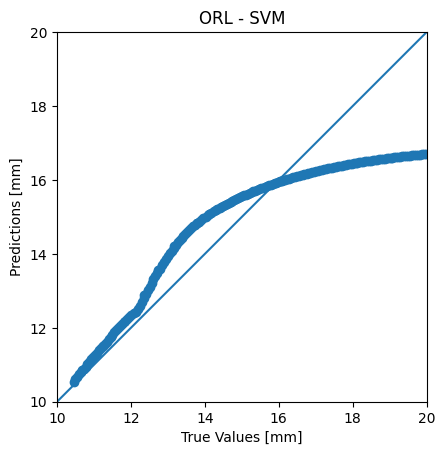

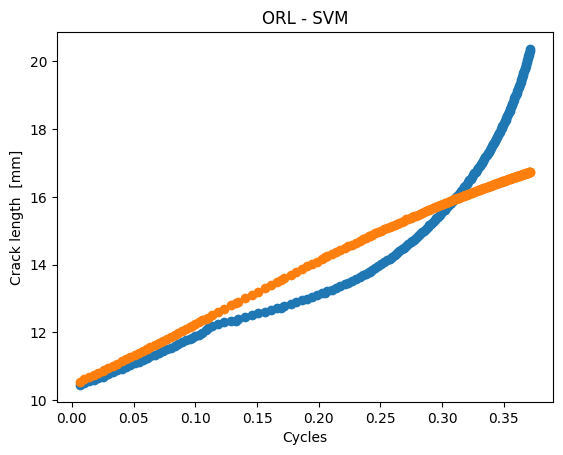

In [223]:
# Predict crack length vs. the number of cycles for OLR using Support Vector Machine

# Train the model
model2 = svm.SVR()

model2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = model2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f'Test MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - SVM')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2)
plt.scatter(X_test2_scaled[:,0], y_pred)
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - SVM')
plt.show()